# 特徴量エンジニアリング
下記の一連の特徴量エンジニアリングを **feature_engineering_prototype2**関数として保存

## ライブラリのインポート

In [1]:
import os
import sys
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))
from conf.config import CFG, DIRS
from utils.load_datas import load_all_datas

## データの読み込み

In [2]:
train_df, test_df = load_all_datas()

## 表記揺れの修正
## home_team, away_team

In [4]:
table = str.maketrans(
    'ＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺ', 'ABCDEFGHIJKLMNOPQRSTUVWXYZ',
)
# home_team
train_df.loc[:, "home_team"] = train_df.loc[:, "home_team"].apply(lambda text: text.translate(table))
test_df.loc[:, "home_team"] = test_df.loc[:, "home_team"].apply(lambda text: text.translate(table))

# away_team
train_df.loc[:, "away_team"] = train_df.loc[:, "away_team"].apply(lambda text: text.translate(table))
test_df.loc[:, "away_team"] = test_df.loc[:, "away_team"].apply(lambda text: text.translate(table))

## カテゴリ変数の変換
## match_date
試合日を<font color="red">**year, month, weekday**</font>に分割。また、祝日データを読み込み祝日かどうかを表す<font color="red">**0,1フラグ**</font>として特徴量に組み込む

In [5]:
# datetimeオブジェクトに変換
train_df["match_date"] = pd.to_datetime(train_df["match_date"])

# 年
train_df["year"] = train_df["match_date"].dt.year
# 月
train_df["month"] = train_df["match_date"].dt.month
# 曜日
train_df["weekday"] = train_df["match_date"].dt.day_name()
# 祝日フラグ
# データのロード
holiday_df = pd.read_csv(os.path.join(DIRS["DATA"], "holidays_in_japan.csv"))
holiday_df["holiday_date"] = pd.to_datetime(holiday_df["holiday_date"])

# 結合
train_df = pd.merge(train_df, holiday_df, left_on="match_date", right_on="holiday_date", how="left")
train_df["is_holiday"] = train_df["description"].apply(lambda val: 0 if pd.isna(val) else 1)



## kick_off_time
kick_off_timeのうち、<font color="red">**時間のみ**</font>を特徴量として組み込む

In [6]:
# datetimeオブジェクトに変換
train_df["kick_off_time"] = pd.to_datetime(train_df["kick_off_time"], format="%H:%M")

# 時間
train_df["hour"] = train_df["kick_off_time"].dt.hour

## section
sectionを数値データとして変換する

In [8]:
def extract_number(val):
    match = re.search(r'\d+', val)
    if match:
        return int(match.group(0))
    else:
        return None
    
train_df["section"] = train_df["section"].apply(extract_number)

## round
roundも同様に数値データに変換

In [12]:
train_df["round"] = train_df["round"].apply(extract_number)

## broadcasters
<font color="red">**録画放送フラグ**、**放送タイプフラグ**</font>を特徴量として追加

In [6]:
def extract_broadcast(row):
    is_recorded = 0
    broadcast_type = "地上波"

    broadcasts = row.split("/")

    for b in broadcasts:
        # 録画放送
        if "(録)" in b:
            is_recorded = 1
        
        # 放送タイプ
        # 放送タイプのチェック
        if 'BS' in b:
            broadcast_type = 'BS'
        elif 'スカパー!' in b or 'J SPORTS' in b:
            broadcast_type = 'CS'
        elif 'MXテレビ' in b:
            broadcast_type = 'インターネット配信'
            
    return pd.Series([is_recorded, broadcast_type])

# 作成
train_df[["is_recorded", "broadcast_type"]] = train_df["broadcasters"].apply(extract_broadcast)

## address
県と市を特徴量として抽出

In [7]:
pattern = re.compile(r'(?P<prefecture>.+?[都道府県])(?P<city>.+?[市区町村])')

def extract_components(address):
    match = pattern.match(address)
    if match:
        return match.groupdict()
    return {'prefecture': None, 'city': None}

component_df = train_df.loc[:, "address"].apply(extract_components).apply(pd.Series)

train_df = pd.concat([train_df, component_df], axis=1)

In [8]:
train_df.columns

Index(['id', 'match_date', 'kick_off_time', 'section', 'round', 'home_team',
       'away_team', 'venue', 'weather', 'temperature', 'humidity',
       'broadcasters', 'attendance', 'home_team_player11',
       'home_team_player10', 'home_team_player9', 'home_team_player8',
       'home_team_player7', 'home_team_player6', 'home_team_player5',
       'home_team_player4', 'home_team_player3', 'home_team_player2',
       'home_team_player1', 'home_team_score', 'away_team_score',
       'away_team_player1', 'away_team_player2', 'away_team_player3',
       'away_team_player4', 'away_team_player5', 'away_team_player6',
       'away_team_player7', 'away_team_player8', 'away_team_player9',
       'away_team_player10', 'away_team_player11', 'capacity', 'address',
       'year', 'month', 'weekday', 'holiday_date', 'description', 'is_holiday',
       'hour', 'is_recorded', 'broadcast_type', 'prefecture', 'city'],
      dtype='object')

In [9]:
# 必要なカラム
feature_col = [
        "section",
        "round",
        "home_team",
        "away_team",
        "temperature",
        "humidity",
        "home_team_score",
        "away_team_score",
        "capacity",
        "year",
        "month",
        "weekday",
        "is_holiday",
        "hour",
        "is_recorded",
        "broadcast_type",
        "prefecture",
        "city",
    ]

target_col = ["attendance"]

CAT_FEATURES = [
        "section",
        "round",
        "home_team",
        "away_team",
        "weekday",
        "broadcast_type",
        "prefecture",
        "city",
    ]

NUM_FEATURES = [
        "temperature",
        "humidity",
        "home_team_score",
        "away_team_score",
        "capacity",
        "year",
        "month",
        "is_holiday",
        "hour",
        "is_recorded",
        "broadcast_type",
    ]

In [10]:
# 切り出し
result = train_df.loc[:, feature_col+target_col]
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   section          3672 non-null   object 
 1   round            3672 non-null   object 
 2   home_team        3672 non-null   object 
 3   away_team        3672 non-null   object 
 4   temperature      3672 non-null   float64
 5   humidity         3672 non-null   int64  
 6   home_team_score  3672 non-null   int64  
 7   away_team_score  3672 non-null   int64  
 8   capacity         3672 non-null   int64  
 9   year             3672 non-null   int32  
 10  month            3672 non-null   int32  
 11  weekday          3672 non-null   object 
 12  is_holiday       3672 non-null   int64  
 13  hour             3672 non-null   int32  
 14  is_recorded      3672 non-null   int64  
 15  broadcast_type   3672 non-null   object 
 16  prefecture       3672 non-null   object 
 17  city          

## チームメンバー

In [16]:
cols = [f"home_team_player{i}" for i in range(2, 12)] + [f"away_team_player{i}" for i in range(1, 12)]
cols

['home_team_player2',
 'home_team_player3',
 'home_team_player4',
 'home_team_player5',
 'home_team_player6',
 'home_team_player7',
 'home_team_player8',
 'home_team_player9',
 'home_team_player10',
 'home_team_player11',
 'away_team_player1',
 'away_team_player2',
 'away_team_player3',
 'away_team_player4',
 'away_team_player5',
 'away_team_player6',
 'away_team_player7',
 'away_team_player8',
 'away_team_player9',
 'away_team_player10',
 'away_team_player11']

In [17]:
members = train_df["home_team_player1"].str.cat(train_df[cols])
members

0       22 藤ヶ谷陽介 GK21 加地亮 DF2 シジクレイ DF6 山口智 DF14 家長昭博 ...
1       1 阿部謙作 GK32 杉山新 DF15 アライール DF20 ビジュ DF4 山本英臣 D...
2       1 土肥洋一 GK25 徳永悠平 DF2 茂庭照幸 DF5 増嶋竜也 DF15 鈴木規郎 D...
3       1 川口能活 GK2 鈴木秀人 DF5 田中誠 DF6 服部年宏 DF11 西紀寛 MF25...
4       22 川島永嗣 GK4 大森征之 DF5 古賀正紘 DF29 深津康太 DF6 有村光史 D...
                              ...                        
3667    1 チョンソンリョン GK18 エウシーニョ DF3 奈良竜樹 DF5 谷口彰悟 DF7 車...
3668    1 河田晃兵 GK5 新里亮 DF4 山本英臣 DF6 エデルリマ DF22 小出悠太 MF...
3669    1 大谷幸輝 GK8 小泉慶 DF50 富澤清太郎 DF4 ソンジュフン DF27 堀米悠斗...
3670    21 カミンスキー GK3 大井健太郎 DF24 小川大貴 DF35 森下俊 DF41 高橋...
3671    30 徳重健太 GK6 高橋峻希 DF3 渡部博文 DF5 岩波拓也 DF39 伊野波雅彦 ...
Name: home_team_player1, Length: 3672, dtype: object

## 特徴量ごとの分布を見てみる

### カテゴリ変数

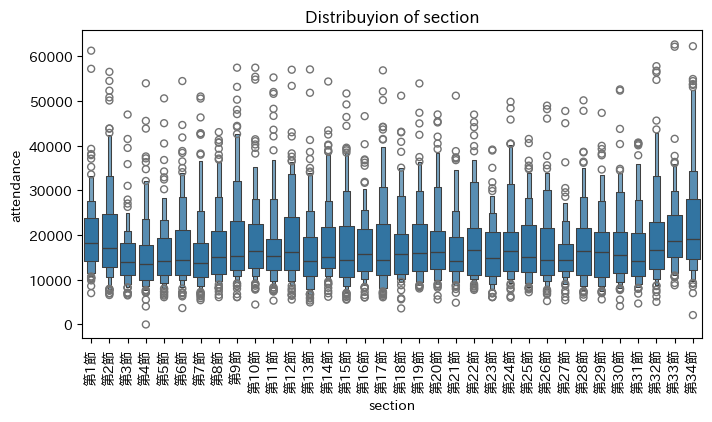

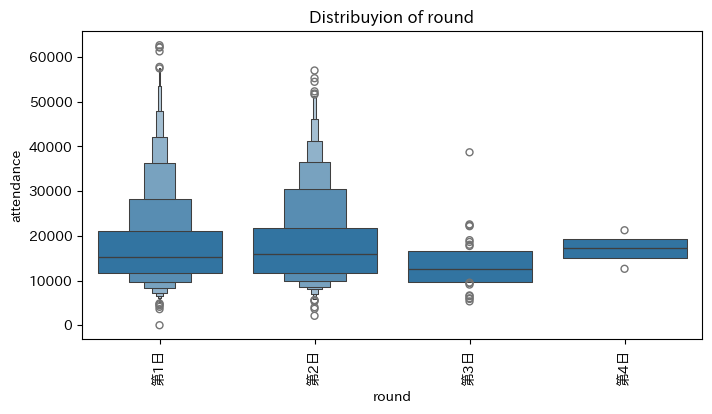

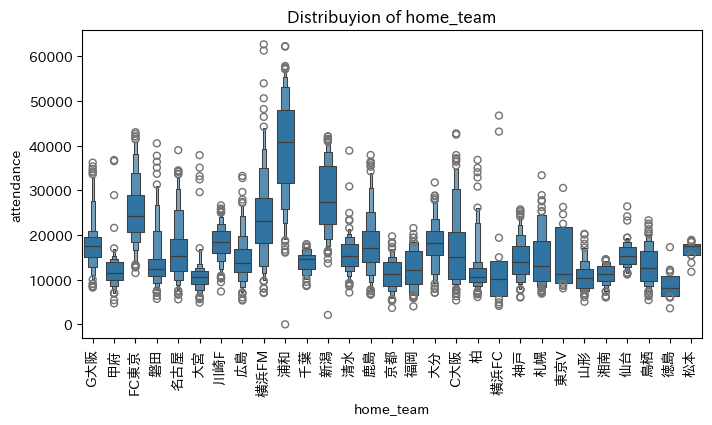

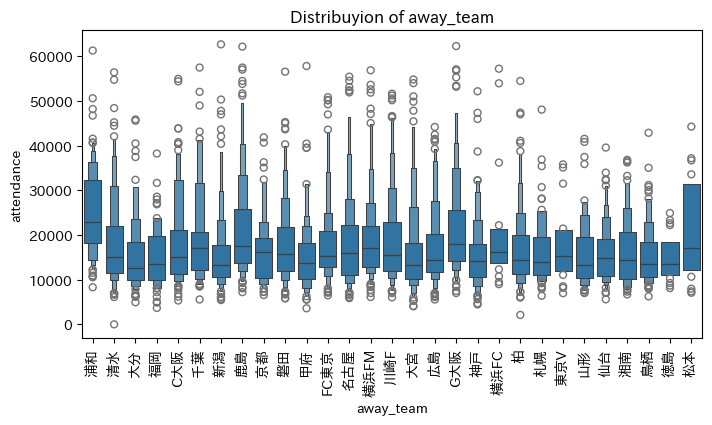

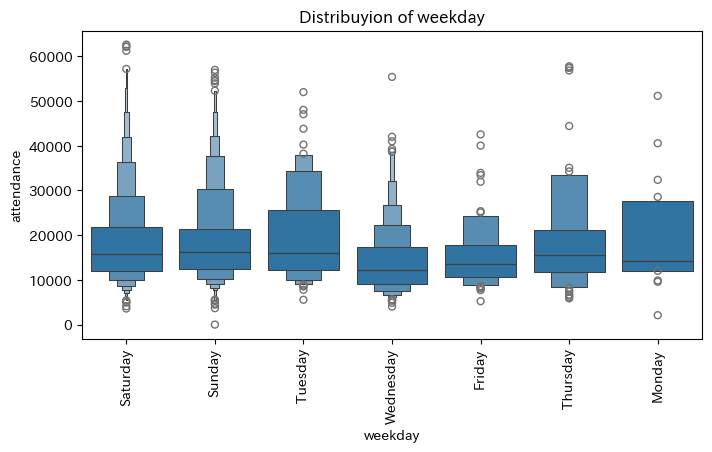

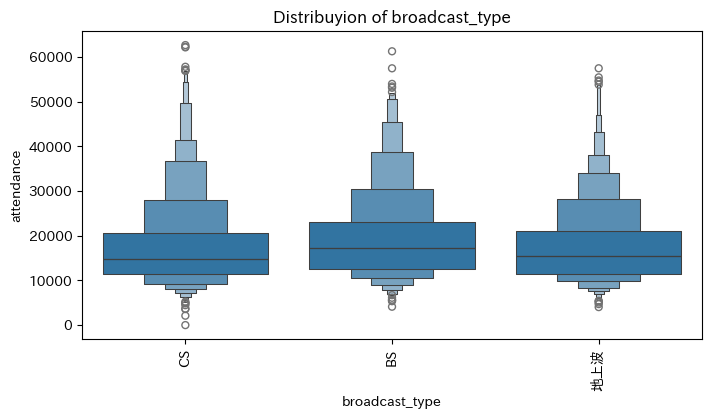

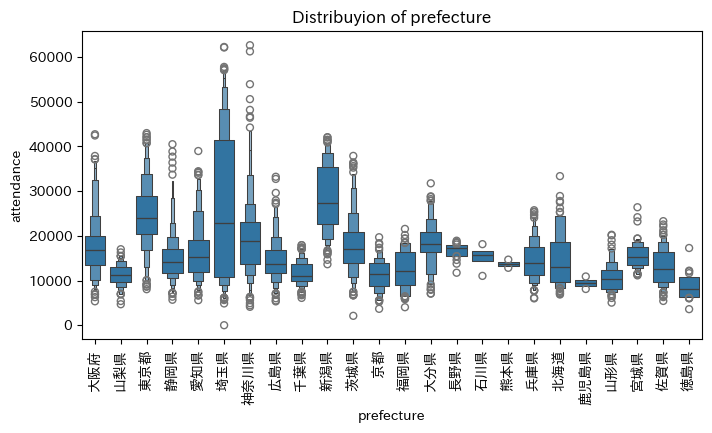

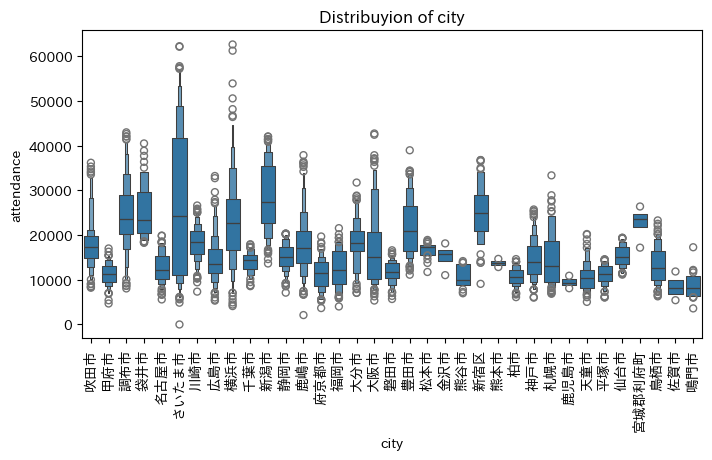

In [11]:
from utils.visualize import plot_cat_distribution, plot_num_target_distribution

plot_cat_distribution(result, CAT_FEATURES, "attendance")

### 数値変数

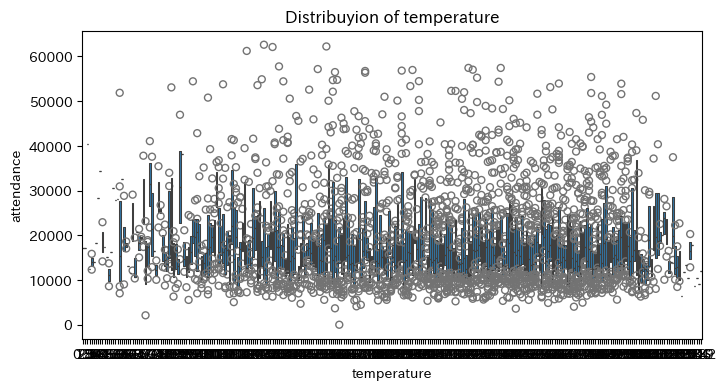

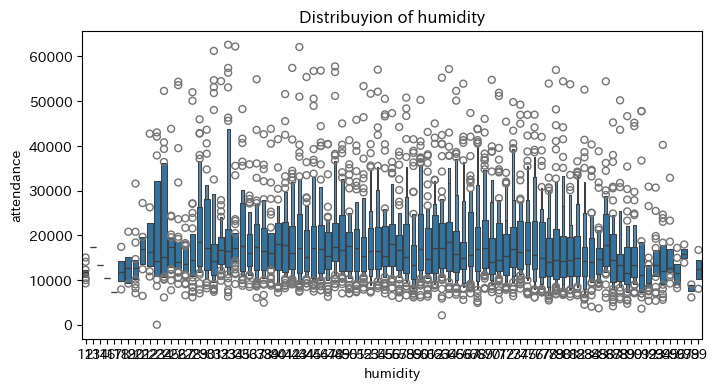

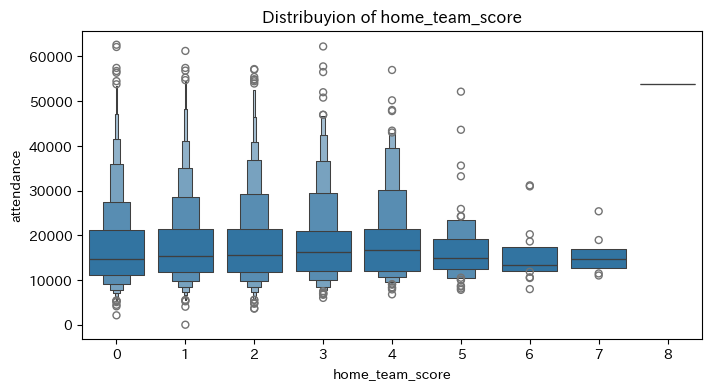

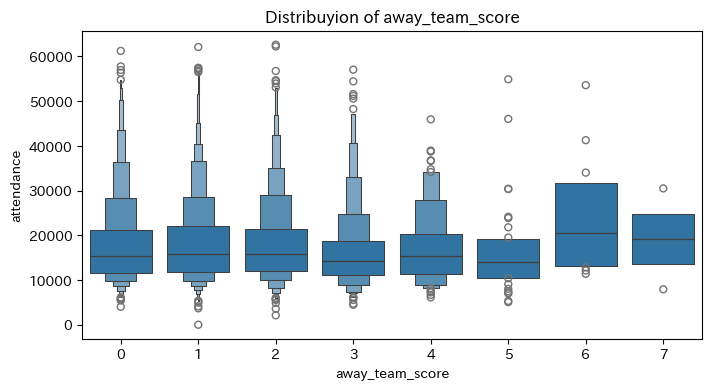

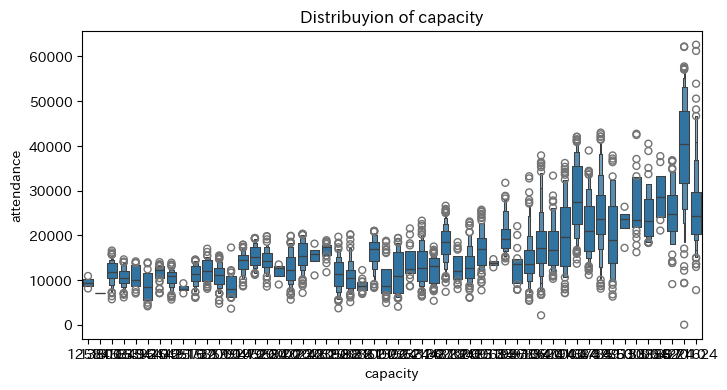

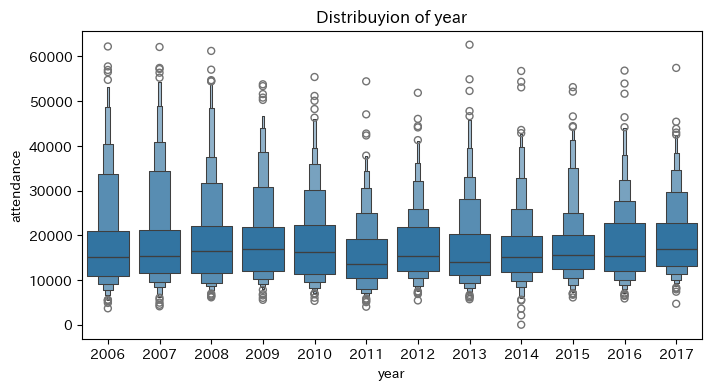

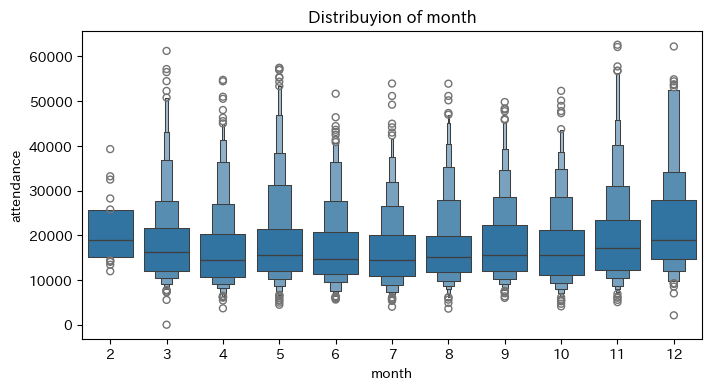

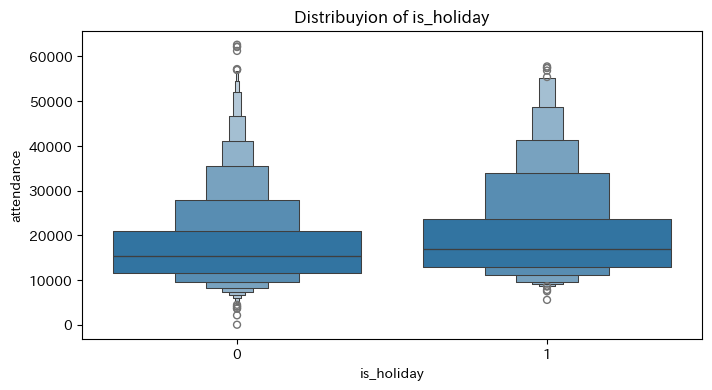

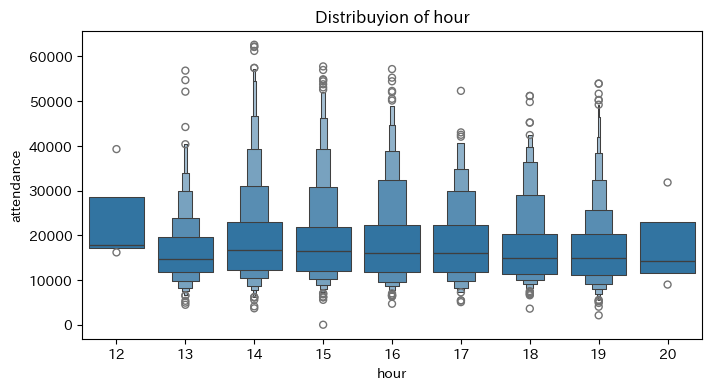

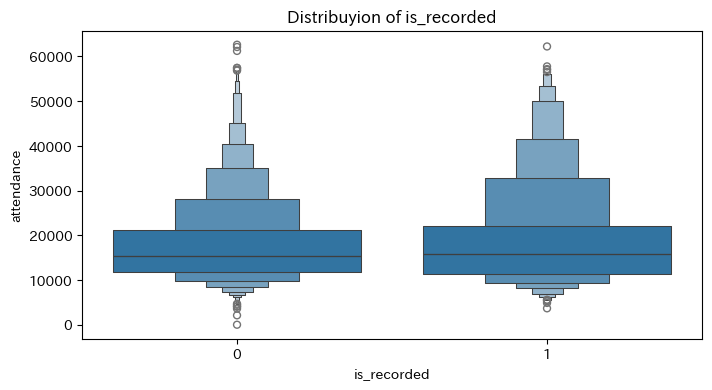

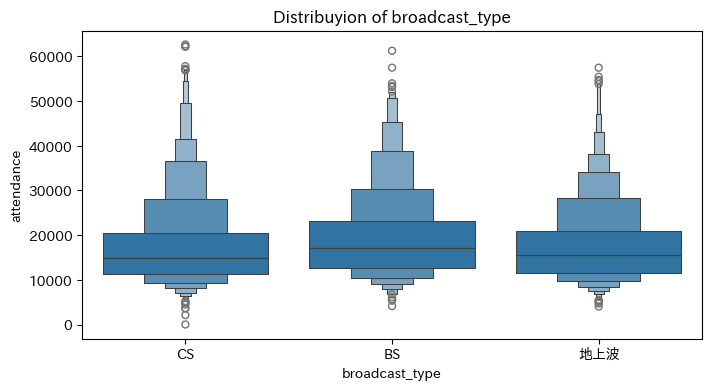

In [12]:
plot_num_target_distribution(result, NUM_FEATURES, "attendance")